# To do

- To make sure there is also 'imaginary progress' when turning around corners, add jump discontinuities at the corners.
- The size of these discontinuities can be given by some radius times the angle the outward facing normal vector has to rotate around the corner.
- To implement this it is helpful to give with each point of the polygon the imaginary value with which the line segment originating at that point starts to the CUDA kernel.

In [1]:
from numba import cuda

import tqdm.notebook as tqdm
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2

## Plotting

In [2]:
def quick_plot(*data, mode = 'imshow', colorbar = True, dpi = 100, title = None, **kwargs):
    
    fig,ax = plt.subplots(dpi = dpi)
    
    if mode == 'imshow':
        p = ax.imshow(*data, **kwargs)
        
        if colorbar:
            plt.colorbar(p, ax = ax)
        
    elif mode == 'plot':
        p = ax.plot(*data, **kwargs)
        
    ax.set_title(title)
        
    fig.tight_layout()
        
    return fig, ax

## Creating source image with text

In [3]:
from PIL import Image, ImageDraw, ImageFont
import numpy as np

font_file_standard = r"C:\Users\bart1\miniconda3\envs\MEP\Lib\site-packages\matplotlib\mpl-data\fonts\ttf\DejaVuSans-Bold.ttf"

def im_with_text(imsize    = (1920,1080),
                 text      = "F r a c t a l",
                 font_size = 250,
                 font_file = font_file_standard,
                 add_offset = (0,0),
                 **kwargs):
    
        im   = Image.new("F", imsize)
        font = ImageFont.truetype(font_file, 
                                  font_size)

        # Attempt to put the text in the middle by getting the size of the bounding box of the text
        _,_,w,h = font.getbbox(text)
        org     = ((imsize[0]-w)//2 + add_offset[0],
                   (imsize[1]-h)//2 + add_offset[1])
        
        draw = ImageDraw.Draw(im)
        draw.text(org, text, font = font, fill = 1, **kwargs)
        
        return np.array(im)

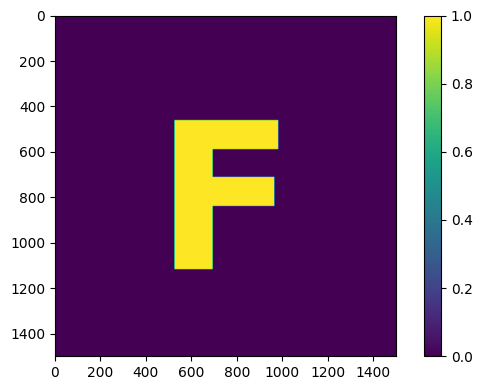

In [4]:
im = im_with_text(imsize = (1500,1500), font_size = 900, text = "F", add_offset = (0,-50))
quick_plot(im, vmin = 0);

## Manually draw and save/load a parametrization of the text boundary

In [5]:
import cv2

class parametrization_getter():
    
    def __init__(self, image, blow_up = 4, show_window = True):
        
        self.image = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)
        
        # BLown up image for easier drawing
        self.image_big = cv2.resize(self.image,(int(blow_up*self.image.shape[1]),
                                                  int(blow_up*self.image.shape[0])))
        self.window_name = "Get parametrizations"
        
        self.polygons      = [[]]
        self.polygon_index = 0
        
        
    def update_window(self):
        
        canvas = self.image_big.copy()
        
        for i,polygon in enumerate(self.polygons):
            if len(polygon) > 1:
                
                color  = (200,255,0) if (i == self.polygon_index) else (0,200,0)
                
                points       = np.array(polygon)
                points[:,0] *= self.image_big.shape[1]
                points[:,1] *= self.image_big.shape[0]
                points       = points.astype(int)
                
                canvas = cv2.polylines(canvas, [points],
                                       True, color, 2)
                
                canvas = cv2.circle(canvas, points[0],  3, (0,0,255), -1)
                canvas = cv2.circle(canvas, points[-1], 3, (0,255,0), -1)
                
        cv2.imshow(self.window_name, canvas)
        
        
    def mouse_callback(self, event, x,y, flags, param):
        
        if event == cv2.EVENT_LBUTTONDOWN:
            point = [x/self.image_big.shape[1],y/self.image_big.shape[0]]
            self.polygons[self.polygon_index].append(point)
            self.update_window()
            
        elif event == cv2.EVENT_RBUTTONDOWN:
            polygon = self.polygons[self.polygon_index]
            if len(polygon) > 0:
                self.polygons[self.polygon_index] = polygon[:-1]
                self.update_window()
                
                
    def run(self):
        
        cv2.namedWindow(self.window_name)
        cv2.setMouseCallback(self.window_name,self.mouse_callback)
        
        self.update_window()
        
        while True:
            key = cv2.waitKey(0)
            
            if key == ord('q'):
                cv2.destroyAllWindows()
                break
                
            elif key == ord('n'):
                if self.polygon_index == len(self.polygons)-1:
                    self.polygons.append([])
                    
                self.polygon_index += 1
                self.update_window()
                
            elif key == ord('p'):
                self.polygon_index = max(0, self.polygon_index-1)
                self.update_window()
                
            elif key == ord('d'):
                
                if len(self.polygons) > 1:
                    del self.polygons[self.polygon_index]
                
                self.polygon_index = min(len(self.polygons)-1, self.polygon_index)
                
    def get_polygon_data(self, r = 50):
        
        polygon_list     = []
        polygon_circomfs = []
        
        shape = self.image.shape

        for polygon in self.polygons:
            if len(polygon) == 0:
                continue

            # Numpy array of polygon with duplicated starting point and ending with nan 
            # to indicate end of polygon (nan are set after computing angles)
            polygon_ = np.array(polygon + polygon[:2])
            
            # Create array with jump discontinuities at vertices
            angle_advances = np.zeros(len(polygon))
            
            x1 = polygon_[:-2]
            x2 = polygon_[1:-1]
            x3 = polygon_[2:]
            
            v1  = x1-x2
            v1 /= np.linalg.norm(v1, axis = 1, keepdims = True)
            
            v2  = x3-x2
            v2 /= np.linalg.norm(v2, axis = 1, keepdims = True)
            
            inner  = np.sum(v1*v2, axis = 1)
            angle  = np.pi - np.arccos(inner)
            angle_ = np.zeros(polygon_.shape[0])
            angle_[1:-1] = angle
            rotat  = r*angle_
            
            polygon_[-1,:] = np.nan
            polygon_       = np.concatenate([polygon_[:,::-1], rotat[:,None]], axis = 1)

            # Scale the polygon vertices back to the size of the image
            polygon_[:,1] *= shape[0]
            polygon_[:,0] *= shape[1]

            polygon_list.append(polygon_)
            
            line_len_sum = np.linalg.norm(polygon_[1:-1,:2]-polygon_[:-2,:2], axis = 1).sum()
            rotation_sum = rotat.sum()

            polygon_circomfs.append(line_len_sum + rotation_sum)

        polygon_list = np.concatenate(polygon_list)
        
        return polygon_list, polygon_circomfs
                
                
    
    def save_polygons(self,filename):
        
        data_dict = dict()
        
        for i,polygon in enumerate(self.polygons):
            data_dict[str(i)] = np.array(polygon)
            
        with open(filename, 'wb') as f:
            np.savez(f, **data_dict)
            
    def load_polygons(self,filename):      
        with open(filename, 'rb') as f:
            
            for polygon in np.load(f).values():
                self.polygons.append([list(polygon[i]) for i in range(polygon.shape[0])])

In [6]:
PG = parametrization_getter(im, blow_up = 0.5)

In [7]:
PG.run()
PG.save_polygons("FRACTAL.npz")

In [8]:
PG.load_polygons("FRACTAL.npz")

In [9]:
from math import ceil, isnan, sqrt

@cuda.jit
def complex_grid_kernel(polygons, polygon_circomfs, out, power):
    
    i,j = cuda.grid(2)
    
    if not ((0 <= i < out.shape[0]) and (0 <= j < out.shape[1])):
        return
    
    real = 1e10
    imag = 0.
    
    weight_sum = 0.
    length_sum = 0.
    
    polygon_index = 0
    
    for k in range(polygons.shape[0]-1):
        
        if isnan(polygons[k,0]):
            continue
        
        if isnan(polygons[k+1,0]):
            polygon_index += 1
            length_sum     = 0.
            continue
            
        inner       = (i-polygons[k,0])*(polygons[k+1,0]-polygons[k,0]) + (j-polygons[k,1])*(polygons[k+1,1]-polygons[k,1])
        line_len_sq = (polygons[k+1,0] - polygons[k,0])**2 + (polygons[k+1,1] - polygons[k,1])**2
        
        if inner < 0:
            t_min = 0
            dist  = sqrt((i - polygons[k,0])**2 + (j - polygons[k,1])**2)
        
        else:
            
            line_len_sq = (polygons[k+1,0] - polygons[k,0])**2 + (polygons[k+1,1] - polygons[k,1])**2
            t_min       = inner/line_len_sq

            if t_min > 1:
                t_min = 1
                dist  = sqrt(max(0,(i - polygons[k+1,0])**2 + (j - polygons[k+1,1])**2))

            else:
                dist = sqrt(max(0,line_len_sq*t_min**2 - 2*inner*t_min + (i - polygons[k,0])**2 + (j - polygons[k,1])**2))
            
        real   = min(real, dist)
        
        
        weight      = 1/(dist + 1e-5)**power
        weight_sum += weight
        line_len    = sqrt(line_len_sq)
        polygon_len = polygon_circomfs[polygon_index]
        val         = polygon_len/2 - abs(length_sum + t_min*line_len - polygon_len/2)
        imag       += val*weight
        length_sum += line_len + polygons[k,2]
            
    imag /= weight_sum
            
    out[i,j] = complex(real,imag)
              
    
def get_complex_grid(pg, power = 3,
                     threads_per_block = (16,16), r = 100):
    
    shape = pg.image.shape[:2]
    
    blocks_per_grid = (ceil(shape[0]/threads_per_block[0]),
                       ceil(shape[1]/threads_per_block[1]))

    polygons, polygon_circomfs = pg.get_polygon_data(r = r)
    
    P  = cuda.to_device(polygons)
    PC = cuda.to_device(polygon_circomfs)
    
    out = cuda.device_array(shape, dtype = np.complex128)
    
    complex_grid_kernel[blocks_per_grid,
                        threads_per_block](P, PC, out, power)
    
    return out, P

In [10]:
out, P = get_complex_grid(PG, power = 8, r = 0)

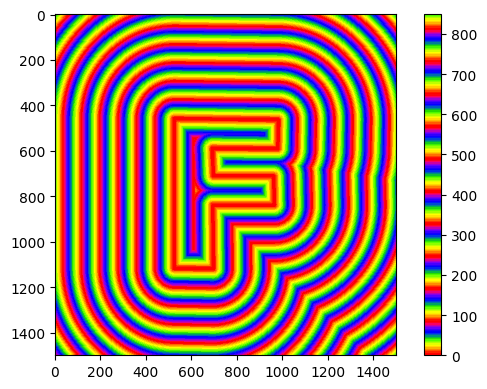

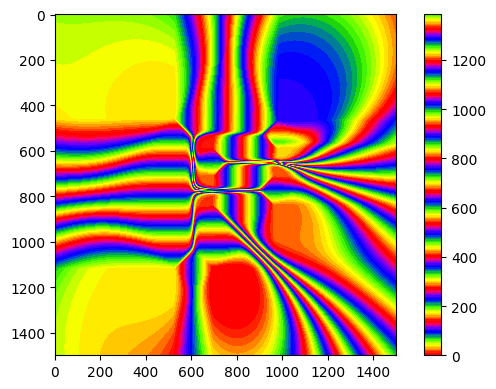

In [11]:
out_host = out.copy_to_host()

quick_plot(out_host.real, cmap = 'prism')
quick_plot(out_host.imag, cmap = 'prism');

## Create fractal

In [12]:
import cupy as cp
    
class Mandelbrot_artist():
    
    def __init__(self,
                 colors: list    = [[100,10,10],[255,100,100]]):
        
        self.colours      = colors
        self.shades_per_c = 500
        
        self.get_colormap()
        
    def get_colormap(self):
        
        colours_looped = cp.array(self.colours + [self.colours[0]])
        f              = cp.linspace(0,1,self.shades_per_c)[:-1,None]
        shades_all     = []
        
        for i in range(len(self.colours)):
            
            shades   = ((1-f) *colours_looped[i][None,:] + 
                        (f)   *colours_looped[i+1][None,:]).astype(cp.uint8)
            
            shades_all.append(shades)
            
        self.colormap = cp.concatenate(shades_all)  
        
    def colour(self, Iters, Div, offset = 0):
        self.fractal_im      = cp.zeros((*Iters.shape,3), dtype = cp.uint8)
        self.fractal_im[Div] = self.colormap[(Iters[Div] + offset) % len(self.colormap)]

In [13]:
points = [-0.75,
-1.25,
-1.3680989,
-1.3940462,
-1.3996312,
-1.4008287,
-1.4010853,
-1.4011402,
-1.401151982029,
-1.401154502237]

def get_inv_param(i):

    c_bulb =  (points[i+1]+points[i])/2
    r_bulb = -(points[i+1]-points[i])/2

    c_inv = c_bulb-r_bulb
    r_inv = 2*r_bulb
    
    return c_inv, r_inv

In [14]:
@cuda.jit
def Mandelbrot_kernel(Z, C, Div, Iters, n_iters_max):
    
    i,j = cuda.grid(2)
    
    if (i >= Z.shape[0]) or (j >= Z.shape[1]) or Div[i,j]:
        return
    
    z   = Z[i,j]
    c   = C[i,j]
    
    for n in range(1,n_iters_max+1):
        z     = z*z + c
        abssq = z.real*z.real + z.imag*z.imag
        
        if abssq > 4:
            Div[i,j] = True
            break
        
    Z[i,j]      = z
    Iters[i,j] += n

In [15]:
class Solutions_to_fractal():
    
    def __init__(self, sol,
                 c_inv = -5/4,
                 r_inv =  1/2):
        
        self.sol = sol
        self.sol/= max(sol.real.max(),
                       sol.imag.max())
        
        self.sol.real = 1 - self.sol.real
        
        self.c_inv = c_inv
        self.r_inv = r_inv
        
        self.scale_imag     = 2
        self.scale_real     = 0.5
        self.translate_imag = 0
        
        self.MA = Mandelbrot_artist()
        
        
    def invert(self,Z):
        diff = Z - self.c_inv
        return self.c_inv + diff*np.square(self.r_inv/np.abs(diff))
    
    def get_complex_grid(self):
        
        Z = self.sol.copy()
        
        #         grid_real = self.c_inv - self.r_inv + (1+self.scale_real*(-1+self.grid_real**grid_real_power))*2*self.r_inv
        Z.real = self.c_inv - self.r_inv + (Z.real.max() + self.scale_real*(Z.real-Z.real.max()))*2*self.r_inv
        # Z.real = self.c_inv - (self.r_inv + 2*self.r_inv*self.sol.real)*self.scale_real
        Z.imag = self.scale_imag*self.sol.imag + self.translate_imag   
        
        self.grid_comp = self.invert(Z)
        
        
    def save_complex_grid(self, filename = 'complex_grid.npy'):
        with open(filename, 'wb') as f:
            np.save(f,self.grid_comp.detach().cpu().numpy())
        
    @staticmethod
    def Mandelbrot(complex_grid,
                   n_iters = 100,
                   threads_per_block = (16,16)):
            
    
        C     = cuda.to_device(complex_grid)
        Z     = cuda.device_array_like(C)
        Div   = cuda.device_array(C.shape, dtype = bool)
        Iters = cuda.device_array(C.shape, dtype = np.uint32)
        
        Z[:]     = 0.
        Iters[:] = 0
        Div[:]   = False
        
        S = complex_grid.shape
    
        blocks_per_grid = (ceil(S[0]/threads_per_block[0]),
                           ceil(S[1]/threads_per_block[1]))

        Mandelbrot_kernel[blocks_per_grid,
                          threads_per_block](Z, C, Div, Iters, n_iters)
        
        Iters_host = Iters.copy_to_host()
        Div_host   = Div.copy_to_host()
        
        return Iters_host, Div_host
    
    
    def show_wrapper(self, n_pixels_real = 100, n_iters = 100, **kwargs):
        
        real_max = self.c_inv + self.r_inv
        real_min = real_max - self.scale_real*2*self.r_inv
        imag_min = self.translate_imag
        imag_max = imag_min + self.scale_imag
        
        n_pixels_imag = int(n_pixels_real*(imag_max-imag_min)/(real_max-real_min))
        real          = np.linspace(real_min,real_max,n_pixels_real)
        imag          = np.linspace(imag_min,imag_max,n_pixels_imag)
        real,imag     = np.meshgrid(real,imag, indexing = 'ij')
        comp          = self.invert(real + 1j*imag)
        raw, div      = Solutions_to_fractal.Mandelbrot(comp, n_iters = n_iters)
        
        self.MA.colour(raw,div)
        im = cp.asnumpy(self.MA.fractal_im)
        
        
        
        fig, ax = quick_plot(im, colorbar = False, extent = [imag_min,imag_max,real_min,real_max], **kwargs)
        
        ax.set_ylabel("real")
        ax.set_xlabel("Imaginary")
        ax.set_title("Wrapper")
        fig.tight_layout()
        
        return fig,ax
        

In [16]:
c_inv, r_inv = get_inv_param(0)

STF = Solutions_to_fractal(out_host, c_inv = c_inv, r_inv = r_inv)

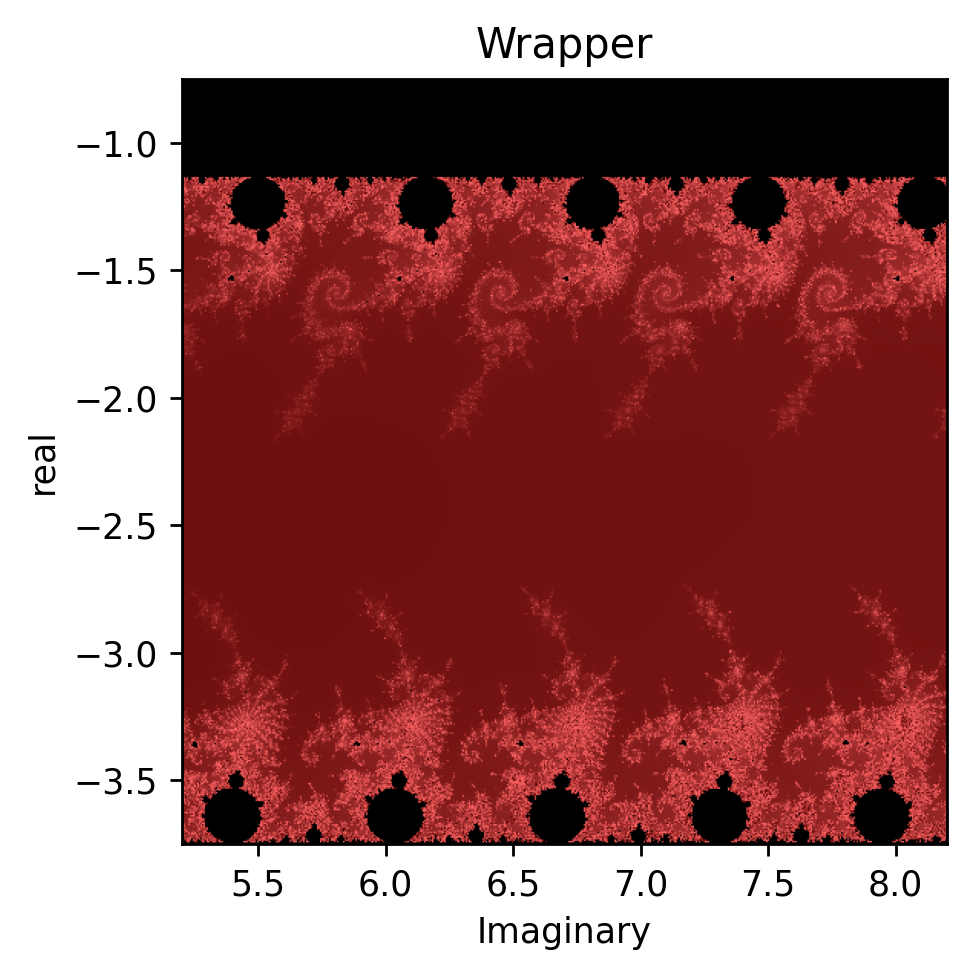

In [17]:
STF.scale_imag     = 3
STF.scale_real     = 3
STF.translate_imag = 5.2

STF.show_wrapper(n_iters = 10000, dpi = 250, n_pixels_real = 500);

In [18]:
STF.get_complex_grid()
raw, div = Solutions_to_fractal.Mandelbrot(STF.grid_comp, n_iters = 100000)

(<Figure size 1500x1000 with 1 Axes>, <AxesSubplot:>)

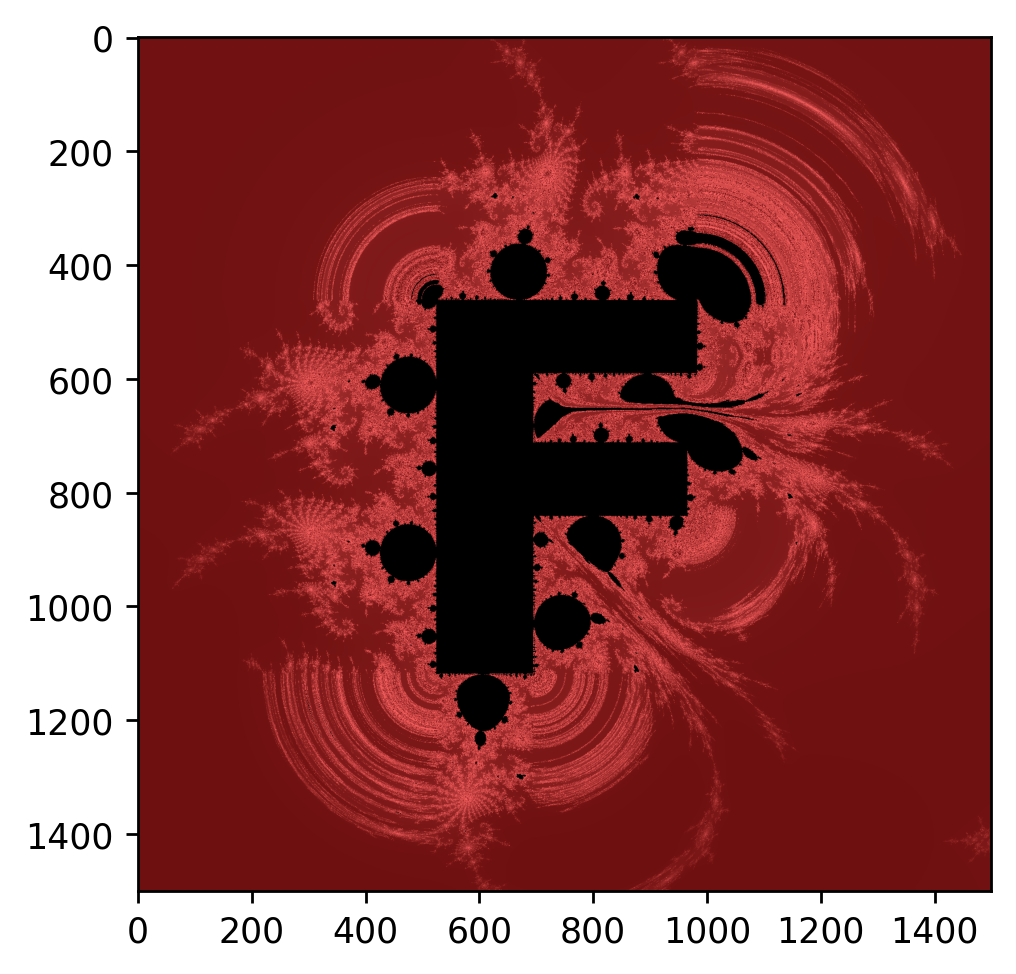

In [19]:
STF.MA.colour(raw,div)

fractal_im = cp.asnumpy(STF.MA.fractal_im)
fractal_im[im != 0] = 0

quick_plot(fractal_im, colorbar = False, dpi = 250)

In [23]:
cv2.imwrite("F_fractal.png", cv2.cvtColor(fractal_im, cv2.COLOR_RGB2BGR))

True